**Note:** It looks like the Phillips Perron Test is an adjustment of the Dicky Fuller Test. So I'm going to copy the code from the DickyFuller notebook & add the Phillips Perron Test stuff to the end.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron

In [2]:
def generate_datapoints(mu, sigma):
    return np.random.normal(mu, sigma)

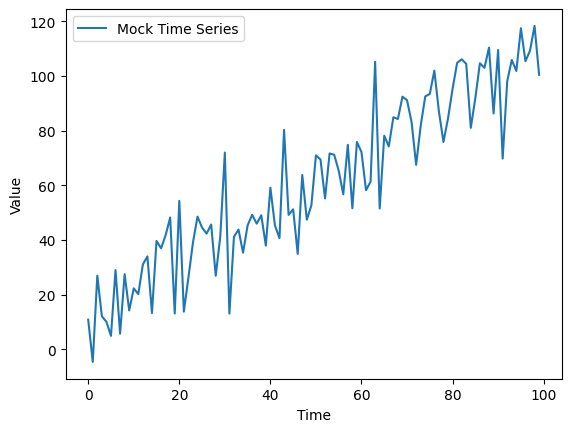

In [3]:
sigma = 12

T = 100

mock = pd.Series(index=range(T),
                  dtype='float64')
mock.name = 'mock time series'

np.random.seed(22)
for t in range(T):
    mock[t] = generate_datapoints(mu=t,
                                   sigma=sigma) + 12

plt.plot(mock)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Mock Time Series'])

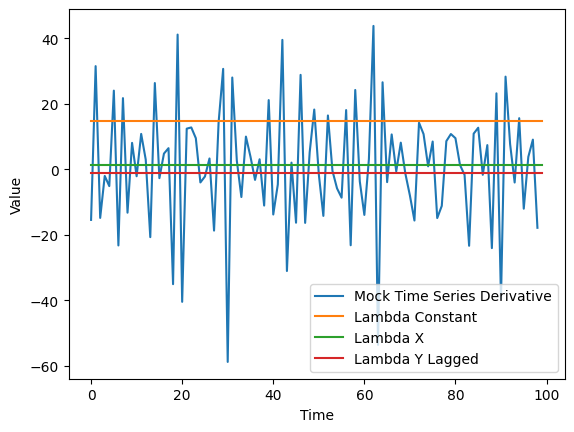

In [4]:
derivative = pd.Series(index=range(T - 1),
                       dtype='float64')

for t in range(1, T):
    derivative[t - 1] = mock[t] - mock[t - 1]

mock_copy = mock.copy().iloc[:-1]

derivative = derivative.to_numpy()
x = np.array([i for i in range(1, 100)])
y_lagged = mock_copy.to_numpy()
constant = np.ones(y_lagged.shape)

A = np.vstack((constant, x, y_lagged)).T
A_transpose_A = np.matmul(A.T, A)
A_transpose_A_inverse =  np.linalg.inv(A_transpose_A)

lambdas = np.matmul(np.matmul(A_transpose_A_inverse, A.T), derivative)

lambda_plot_constant = pd.Series(index=range(T - 1),
                                 dtype='float64')
lambda_plot_x = pd.Series(index=range(T - 1),
                          dtype='float64')
lambda_plot_y_lagged = pd.Series(index=range(T - 1),
                                 dtype='float64')

for t in range(T):
    lambda_plot_constant[t] = lambdas[0] # alpha
    lambda_plot_x[t] = lambdas[1] # beta
    lambda_plot_y_lagged[t] = lambdas[2] # lambda
    
plt.plot(derivative)
plt.plot(lambda_plot_constant)
plt.plot(lambda_plot_x)
plt.plot(lambda_plot_y_lagged)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Mock Time Series Derivative', 'Lambda Constant', 'Lambda X', 'Lambda Y Lagged'])

In [5]:
num_of_observations = 99
k_parameters = 3

y_predict = np.matmul(A, lambdas)
residuals = derivative - y_predict
sigma_square = np.sum(np.square(residuals)) / (num_of_observations - k_parameters)

var_beta = sigma_square * np.linalg.inv(np.matmul(A.T, A))
std_errors = np.sqrt(np.diag(var_beta))

t_stat = lambdas / std_errors
t_stat

array([  5.68518422,  11.76541352, -12.80539779])

In [6]:
# verify
adfuller(x=mock,
         maxlag=0,
         regression="ct",
         autolag=None)

(np.float64(-12.805397794880239),
 np.float64(2.448341782010799e-20),
 0,
 99,
 {'1%': np.float64(-4.053254236405479),
  '5%': np.float64(-3.455806184392646),
  '10%': np.float64(-3.1535907061122397)})

In [7]:
# todo: figure out why this is different from Arch implementation
error_variance = (1 / num_of_observations) * np.sum(np.square(residuals))

mean_residuals = np.mean(residuals)
autocovariance = np.sum((residuals[1:] - mean_residuals) * (residuals[:-1] - mean_residuals)) / num_of_observations

weight_factor = 0.5 # Bartlett Kernel (Newey-West)
long_run_variance = error_variance + 2 * weight_factor * autocovariance

adjusted_t_stat = t_stat - (long_run_variance - error_variance) / (2 * (np.sum(np.square(y_lagged))))
adjusted_t_stat

array([  5.68518662,  11.76541592, -12.80539539])

In [8]:
# verify
PhillipsPerron(mock, trend="ct", lags=1)

Test Statistic,-12.833
P-value,0.000
Lags,1
